In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 三、动手实现 softmax 回归
1.要求动手从0实现 softmax 回归（只借助Tensor和Numpy相关的库）在Fashion-MNIST数据集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析（要求从零实现交叉熵损失函数）

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
batch_size = 256
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [3]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [5]:
# 实现softmax函数
def softmax(X):
    X_exp = torch.exp(X - torch.max(X, dim=1, keepdim=True).values)
    return X_exp / X_exp.sum(1, keepdims=True) 

# 验证softmax函数
X = torch.rand((2, 5))
X1 = softmax(X)
print(X1, X1.sum(1))
X2 = F.softmax(X,dim=1)
print(X2, X2.sum(1))
X1 - X2

tensor([[0.1082, 0.2788, 0.2041, 0.2245, 0.1844],
        [0.2786, 0.1459, 0.2324, 0.1649, 0.1782]]) tensor([1.0000, 1.0000])
tensor([[0.1082, 0.2788, 0.2041, 0.2245, 0.1844],
        [0.2786, 0.1459, 0.2324, 0.1649, 0.1782]]) tensor([1., 1.])


tensor([[ 0.0000e+00,  0.0000e+00, -1.4901e-08, -1.4901e-08,  0.0000e+00],
        [ 0.0000e+00,  1.4901e-08, -1.4901e-08,  0.0000e+00,  0.0000e+00]])

In [6]:
# 交叉熵损失函数
def cross_entropy(y_hat, y):
    """
    Parameters
    y_hat: 预测值，shape is (batch_size, class_num)
    y: 真值，shape is (batch_size, )
    """
    return - torch.log(y_hat.gather(1, y.view(-1, 1))).mean()
# def cross_entropy(y_pred, y):
#     return -torch.log(1e-10 + y_pred[list(range(len(y))), y]).mean()

# 验证交叉熵损失函数
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.tensor([0, 2])
print(F.cross_entropy(y_hat, y) == cross_entropy(softmax(y_hat), y))

tensor(True)


In [7]:
# 初始化参数
num_inputs = 1 * 28 * 28
num_outputs = 10
w = torch.normal(0, 0.01, (num_inputs, num_outputs), dtype=torch.float32).to(device)
b = torch.zeros(num_outputs, dtype=torch.float32).to(device)
w.requires_grad_(True)
b.requires_grad_(True)

# 定义模型
def softmax_regression(X):
    return softmax(torch.mm(X.view(-1, num_inputs), w) + b)


In [8]:
# 定义准确率
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

# 定义优化器
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            # 根据sgd的公式，这里需要除batch_size
            # 为了与pytorch保持一致，计算loss时采用了.mean()操作，相当于已经除过了batch_size，所以这里不除
            # 经验证，最终实现与pytorch自带的SGD效果一致
            # param -= lr * param.grad / batch_size
            param -= lr * param.grad
            param.grad.zero_()

# 定义超参数
lr = 0.03
num_epochs = 100
batch_size = 256

model = softmax_regression
loss_fn = cross_entropy

# 记录训练和测试的损失和准确率
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 训练
for epoch in range(num_epochs):
    train_loss = 0
    train_accuracy = 0
    test_loss = 0
    test_accuracy = 0
    train_batch_num = 0
    test_batch_num = 0
    
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)

        loss = loss_fn(pred, y)
        loss.backward()
        sgd([w, b], lr, batch_size)
        w.grad.zero_()
        b.grad.zero_()
        
        train_loss += loss.item()
        train_accuracy += accuracy(pred, y)
        train_batch_num += 1
        
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_accuracy += accuracy(pred, y)
            test_batch_num += 1

    train_loss /= train_batch_num
    train_accuracy /= train_batch_num          
    test_loss /= test_batch_num
    test_accuracy /= test_batch_num

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/60], Train Loss: 1.0331, Train Accuracy: 0.6953, Test Loss: 0.7831, Test Accuracy: 0.7410
Epoch [2/60], Train Loss: 0.7083, Train Accuracy: 0.7764, Test Loss: 0.6787, Test Accuracy: 0.7768
Epoch [3/60], Train Loss: 0.6369, Train Accuracy: 0.7977, Test Loss: 0.6430, Test Accuracy: 0.7851
Epoch [4/60], Train Loss: 0.5976, Train Accuracy: 0.8083, Test Loss: 0.6001, Test Accuracy: 0.8025
Epoch [5/60], Train Loss: 0.5714, Train Accuracy: 0.8166, Test Loss: 0.5795, Test Accuracy: 0.8079
Epoch [6/60], Train Loss: 0.5533, Train Accuracy: 0.8201, Test Loss: 0.5645, Test Accuracy: 0.8127
Epoch [7/60], Train Loss: 0.5385, Train Accuracy: 0.8247, Test Loss: 0.5581, Test Accuracy: 0.8117
Epoch [8/60], Train Loss: 0.5267, Train Accuracy: 0.8285, Test Loss: 0.5452, Test Accuracy: 0.8175
Epoch [9/60], Train Loss: 0.5174, Train Accuracy: 0.8296, Test Loss: 0.5349, Test Accuracy: 0.8198
Epoch [10/60], Train Loss: 0.5094, Train Accuracy: 0.8314, Test Loss: 0.5298, Test Accuracy: 0.8216
Epoch [11

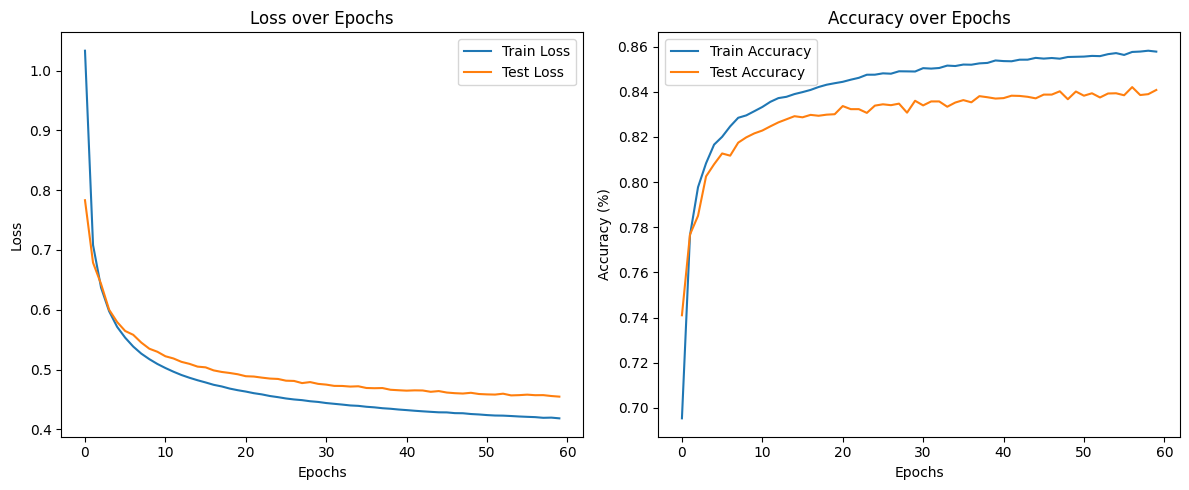

In [9]:
# 可视化结果
def show():
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
show()

2.利用torch.nn实现 softmax 回归在Fashion-MNIST数据集上进行训练和测试，并从loss，训练集以及测试集上的准确率等多个角度对结果进行分析


In [10]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [11]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, x):
        return self.linear(x.view(-1, num_inputs))

num_inputs = 1 * 28 * 28
num_outputs = 10
model = SoftmaxRegression(num_inputs, num_outputs).to(device)
from torch.nn import init
init.normal_(model.linear.weight, mean=0, std=0.01)
init.constant_(model.linear.bias, val=0)   

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)

In [12]:
# 使用pytorch自带的交叉熵损失函数和SGD优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

In [13]:
# 记录训练和测试的损失和准确率
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 训练
for epoch in range(num_epochs):
    train_loss = 0
    train_accuracy = 0
    test_loss = 0
    test_accuracy = 0
    train_batch_num = 0
    test_batch_num = 0
    
    model.train()
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_accuracy += accuracy(pred, y)
        train_batch_num += 1
        
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_accuracy += accuracy(pred, y)
            test_batch_num += 1

    train_loss /= train_batch_num
    train_accuracy /= train_batch_num          
    test_loss /= test_batch_num
    test_accuracy /= test_batch_num

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/60], Train Loss: 1.0369, Train Accuracy: 0.6928, Test Loss: 0.7807, Test Accuracy: 0.7482
Epoch [2/60], Train Loss: 0.7088, Train Accuracy: 0.7759, Test Loss: 0.6783, Test Accuracy: 0.7806
Epoch [3/60], Train Loss: 0.6362, Train Accuracy: 0.7986, Test Loss: 0.6298, Test Accuracy: 0.7895
Epoch [4/60], Train Loss: 0.5975, Train Accuracy: 0.8088, Test Loss: 0.6034, Test Accuracy: 0.7995
Epoch [5/60], Train Loss: 0.5716, Train Accuracy: 0.8155, Test Loss: 0.5811, Test Accuracy: 0.8079
Epoch [6/60], Train Loss: 0.5527, Train Accuracy: 0.8213, Test Loss: 0.5638, Test Accuracy: 0.8128
Epoch [7/60], Train Loss: 0.5383, Train Accuracy: 0.8250, Test Loss: 0.5524, Test Accuracy: 0.8147
Epoch [8/60], Train Loss: 0.5267, Train Accuracy: 0.8267, Test Loss: 0.5432, Test Accuracy: 0.8166
Epoch [9/60], Train Loss: 0.5176, Train Accuracy: 0.8299, Test Loss: 0.5356, Test Accuracy: 0.8201
Epoch [10/60], Train Loss: 0.5092, Train Accuracy: 0.8320, Test Loss: 0.5275, Test Accuracy: 0.8215
Epoch [11

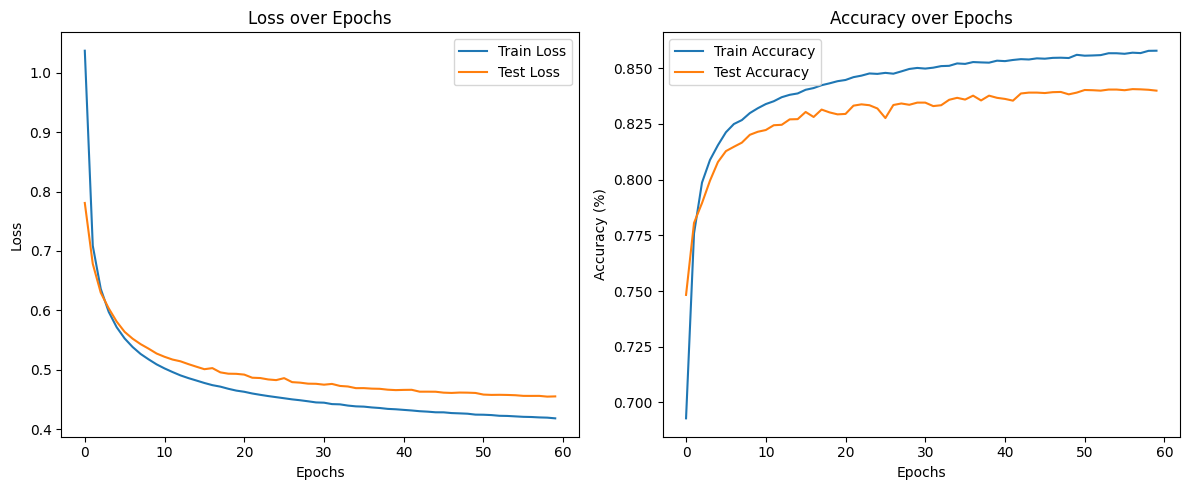

In [14]:
show()